## Multi-modal RAG

[See Trace of Option 3](https://smith.langchain.com/public/db0441a8-2c17-4070-bdf7-45d4fdf8f517/r/80cb0f89-1766-4caf-8959-fc43ec4b071c)

Many documents contain a mixture of content types, including text and images. 

Yet, information captured in images is lost in most RAG applications.

With the emergence of multimodal LLMs, like [GPT-4V](https://openai.com/research/gpt-4v-system-card), it is worth considering how to utilize images in RAG:

`Option 1:` 

* Use multimodal embeddings (such as [CLIP](https://openai.com/research/clip)) to embed images and text
* Retrieve both using similarity search
* Pass raw images and text chunks to a multimodal LLM for answer synthesis 

`Option 2:` 

* Use a multimodal LLM (such as [GPT-4V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve text 
* Pass text chunks to an LLM for answer synthesis 

`Option 3` (Shown) 

* Use a multimodal LLM (such as [GPT-4V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve image summaries with a reference to the raw image 
* Pass raw images and text chunks to a multimodal LLM for answer synthesis   

This cookbook highlights `Option 3`. 

* We will use [Unstructured](https://unstructured.io/) to parse images, text, and tables from documents (PDFs).
* We will use the [multi-vector retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) with [Chroma](https://www.trychroma.com/) to store raw text and images along with their summaries for retrieval.

A seperate cookbook highlights `Option 1` [here](https://github.com/langchain-ai/langchain/blob/master/cookbook/multi_modal_RAG_chroma.ipynb).

And option `Option 2` is appropriate for cases when a multi-modal LLM cannot be used for answer synthesis (e.g., cost, etc).

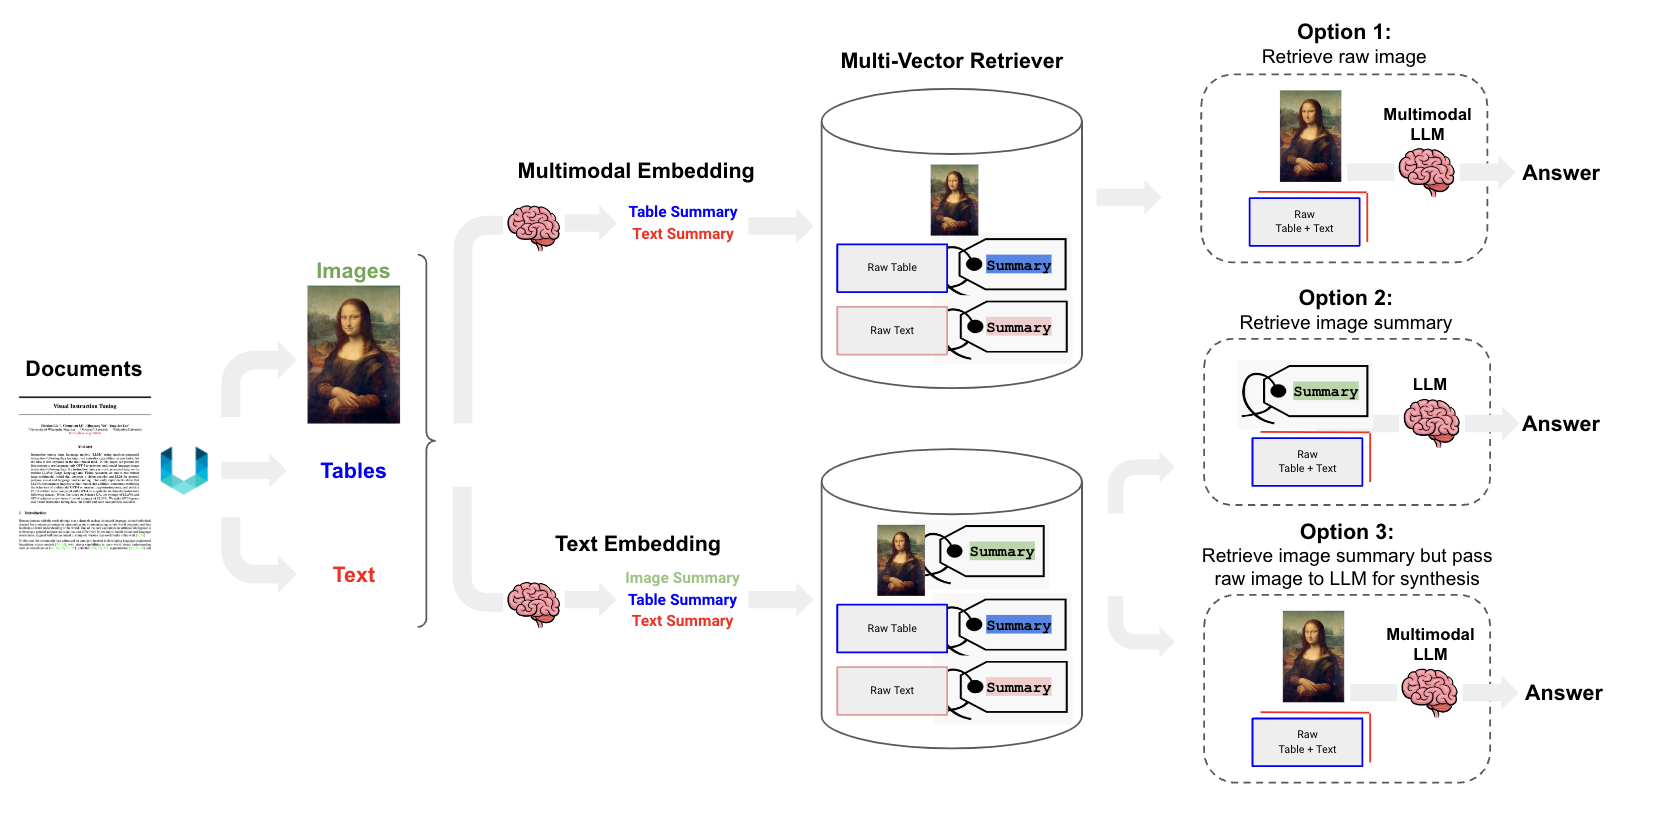

## Packages

In addition to the below pip packages, you will also need `poppler` ([installation instructions](https://pdf2image.readthedocs.io/en/latest/installation.html)) and `tesseract` ([installation instructions](https://tesseract-ocr.github.io/tessdoc/Installation.html)) in your system.

In [ ]:
! pip install "openai>=1" "langchain>=0.0.331rc2"

In [ ]:
! pip install "unstructured[all-docs]" pillow pydantic lxml pillow matplotlib chromadb tiktoken

## Data Loading

### Partition PDF tables, text, and images
  
Let's look at an [example whitepaper](https://sgp.fas.org/crs/misc/IF10244.pdf) that provides a mixture of tables, text, and images about Wildfires in the US.

We use Unstructured to partition it (see [blog post](https://blog.langchain.dev/semi-structured-multi-modal-rag/)).

In [2]:
path = "/Users/rlm/Desktop/wildfire_stats/"

In [ ]:
from unstructured.partition.pdf import partition_pdf

# Extract images, tables, and chunk text
raw_pdf_elements = partition_pdf(
    filename=path + "wildfire_stats.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

In [4]:
# Categorize by type
tables = []
texts = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))

## Multi-vector retriever

Use [multi-vector-retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary).

### Text and Table summaries

Summaries are used to retrieve raw tables and / or raw chunks of text.

In [6]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

In [7]:
# Prompt
prompt_text = """You are an assistant tasked with summarizing tables and text. \ 
Give a concise summary of the table or text. Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatOpenAI(temperature=0, model="gpt-4")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [ ]:
# Apply to text
# Typically this is reccomended only if you have large text chunks
text_summaries = texts  # Skip it

# Apply to tables
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

### Image summaries 

We will use [GPT4-V](https://openai.com/research/gpt-4v-system-card) to produce the image summaries.

See the traces for each of the 5 ingested images here ([1](https://smith.langchain.com/public/f5548212-2e70-4fa8-91d6-c3e7d768d52b/r), 
[2](https://smith.langchain.com/public/8b198178-5b83-4960-bbc1-c10516779208/r), 
[3](https://smith.langchain.com/public/c4fcbcd5-38fb-462a-9ed1-e90b1d009fa9/r), 
[4](https://smith.langchain.com/public/1df53c23-63b8-4f87-b5ae-e9d59b2a54ab/r), 
[5](https://smith.langchain.com/public/f93efd6c-f9f6-46c9-b169-29270d33ad63/r))

In [9]:
import io
import os
import base64
import numpy as np
from PIL import Image
from langchain.chat_models import ChatOpenAI
from langchain.schema.messages import HumanMessage, SystemMessage


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    """Image summary"""
    chat = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=1024)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


# Store base64 encoded images
img_base64_list = []

# Store image summaries
image_summaries = []

# Prompt
prompt = "Describe the image in detail. Be specific about graphs, such as bar plots."

# Read images, encode to base64 strings
for img_file in sorted(os.listdir(path)):
    if img_file.endswith(".jpg"):
        img_path = os.path.join(path, img_file)
        base64_image = encode_image(img_path)
        img_base64_list.append(base64_image)
        image_summaries.append(image_summarize(base64_image, prompt))


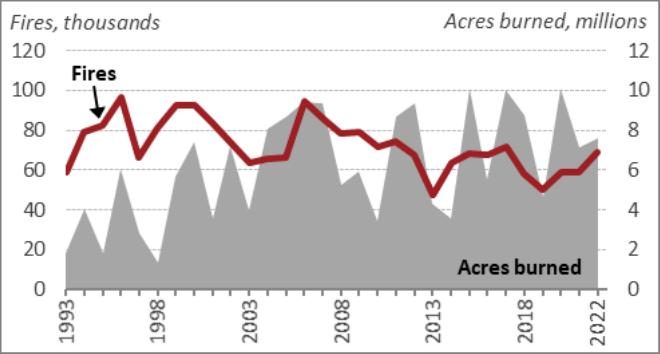

In [10]:
from IPython.display import display, HTML


def plt_img_base64(img_base64):
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'

    # Display the image by rendering the HTML
    display(HTML(image_html))


plt_img_base64(img_base64_list[1])

In [11]:
image_summaries[1]

"This is a dual-axis line chart that illustrates two different datasets over a 30-year period from 1993 to 2022. On the left vertical axis, we have the number of fires, measured in thousands, which goes from 0 to 120. On the right vertical axis, there's the number of acres burned, measured in millions, which ranges from 0 to 12.\n\nThe chart shows two lines: one for the number of fires and one for the acres burned. The line representing fires is a solid red line, and it fluctuates over the years, with some peaks and troughs. It appears to have a slight overall downward trend over the 30-year span. The line for acres burned is represented by a gray area chart with a darker outline, and it also shows variability. Notably, the acres burned appear to have an overall upward trend, with some years having significantly higher values than others.\n\nThe data points are marked annually, with each year labeled at the bottom of the chart from 1993 to 2022. The chart seems to indicate that while t

### Add to vectorstore

Add raw docs and doc summaries to [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary).

In [12]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings()
)

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

* Store the raw texts and tables in the `docstore`.
* Store the table summaries in the `vectorstore` for semantic retrieval.
* Use the tables in answer synthesis.

In [13]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=s, metadata={id_key: table_ids[i]})
    for i, s in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

* Store the images in the `docstore`.
* Store the image summaries in the `vectorstore` for semantic retrieval.
* Using the image in answer synthesis with a multimodal LLM.

In [14]:
# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in img_base64_list]
summary_img = [
    Document(page_content=s, metadata={id_key: img_ids[i]})
    for i, s in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, img_base64_list)))

### Check retrieval

The mult-vector retriever will return base64-encoded images or text documents.

Confirm we can get images back based on natural language search.

Here is our retrieval of that table from the natural language query:

In [15]:
# Retrieve
docs = retriever.get_relevant_documents(
    "What is the change in wild fires from 1993 to 2022?"
)


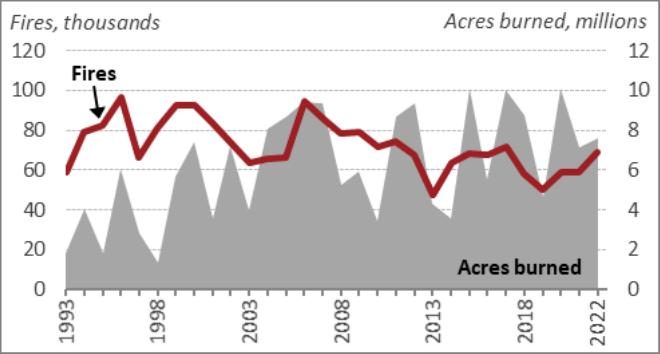

In [16]:
from base64 import b64decode


def split_image_text_types(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


docs_by_type = split_image_text_types(docs)
plt_img_base64(docs_by_type["images"][0])

## RAG

Currently, we format the inputs using a `RunnableLambda` while we add image support to `ChatPromptTemplates`.

Our runnable follows the classic RAG flow - 

* We first compute the context (both "texts" and "images" in this case) and the question (just a RunnablePassthrough here) 
* Then we pass this into our prompt template, which is a custom function that formats the message for the gpt-4-vision-preview model. 
* And finally we parse the output as a string.

In [17]:
from operator import itemgetter
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda


def prompt_func(dict):
    format_texts = "\n".join(dict["context"]["texts"])
    return [
        HumanMessage(
            content=[
                {
                    "type": "text",
                    "text": f"""Answer the question based only on the following context, which can include text, tables, and the below image:
Question: {dict["question"]}

Text and tables:
{format_texts}
""",
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{dict['context']['images'][0]}"
                    },
                },
            ]
        )
    ]


model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)

# RAG pipeline
chain = (
    {
        "context": retriever | RunnableLambda(split_image_text_types),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(prompt_func)
    | model
    | StrOutputParser()
)

In [20]:
chain.invoke("What is the change in wild fires from 1993 to 2022?")

'Based on the provided image, which shows a graph of annual wildfires and acres burned from 1993 to 2022, there is a noticeable fluctuation in both the number of fires and the acres burned over the years. In 1993, the number of fires was around 80,000, and the acres burned were approximately 2 million. By 2022, the number of fires appears to have decreased slightly to just under 80,000, while the acres burned have increased significantly to around 10 million.\n\nTherefore, from 1993 to 2022, the change in wildfires shows a slight decrease in the number of fires but a substantial increase in the total acres burned.'

Here is the [trace](https://smith.langchain.com/public/db0441a8-2c17-4070-bdf7-45d4fdf8f517/r/80cb0f89-1766-4caf-8959-fc43ec4b071c). 